# Estimating a regional field
Here we will present the 4 methods we provide for estimating the regional component of gravity.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import plotting, regional, synthetic, utils

## Create observed gravity data
Create 2 synthetic surfaces, an upper one with shorter wavelength topographic features, and a lower once with longer wavelength features. The upper surface will produce the gravity component of interest, the **residual**, and the lower surface will produce the gravity component we aim to estimate and remove, the **regional**. We will create prism layers for both of these layers, forward model them onto a set of gravity observation points. The combined forward gravity effect of these layes, with some added noise, will represent the observed gravity. 

In [2]:
# set grid parameters
spacing = 500
region = [0, 40000, 0, 30000]

# create upper synthetic topography data
upper_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

# create lower synthetic topography data
lower_topography = synthetic.synthetic_topography_regional(
    spacing,
    region,
    scale=3,
    yoffset=-1000,
)

In [3]:
# create constraint points by sampling upper surface at random locations
num_constraints = 30
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, upper_topography, "upward", coord_names=("easting", "northing")
)

### Prism layers

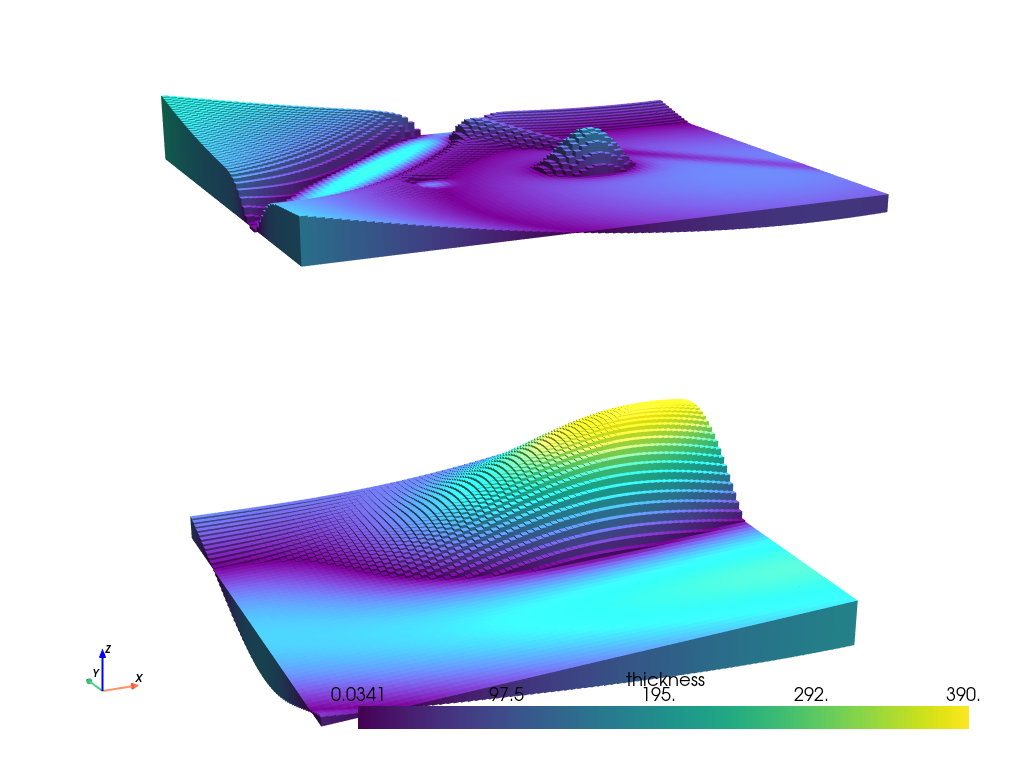

In [4]:
# the density contrast is between sediment (~1800 kg/m3) and air (~1 kg/m3)
density_contrast = 1800

# prisms are created between the mean topography value and the height of the topography
zref = upper_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(upper_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
upper_prisms = utils.grids_to_prisms(
    upper_topography,
    zref,
    density=density,
)

# the density contrast is between mantle (~3300 kg/m3) and rock (~2670 kg/m3)
density_contrast = 3300 - 2670

# prisms are created between the mean topography value and the height of the topography
zref = lower_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(lower_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
lower_prisms = utils.grids_to_prisms(
    lower_topography,
    zref,
    density=density,
)

plotting.show_prism_layers(
    [upper_prisms, lower_prisms],
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

### Forward gravity of prism layers

In [5]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

# forward gravity of upper surface prisms
grav_df["upper_surface_grav"] = upper_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
# forward gravity of lower surface prisms
grav_df["lower_surface_grav"] = lower_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df["grav"] = grav_df.upper_surface_grav + grav_df.lower_surface_grav
grav_df

  0%|                                                                                                         …

  0%|                                                                                                         …

,northing,easting,upward,upper_surface_grav,lower_surface_grav,grav
0,0.0,0.0,1000.0,4.702821,-0.202223,4.500598
1,0.0,500.0,1000.0,5.761512,-0.222749,5.538763
2,0.0,1000.0,1000.0,5.940439,-0.249743,5.690695
3,0.0,1500.0,1000.0,5.886537,-0.282511,5.604025
4,0.0,2000.0,1000.0,5.748903,-0.319520,5.429383
...,...,...,...,...,...,...
4936,30000.0,38000.0,1000.0,1.911976,2.460550,4.372526
4937,30000.0,38500.0,1000.0,1.900899,2.334675,4.235573
4938,30000.0,39000.0,1000.0,1.866645,2.166577,4.033222
4939,30000.0,39500.0,1000.0,1.760582,1.949704,3.710287


,northing,easting,upward,upper_surface_grav,lower_surface_grav,grav,observed_grav
0,0.0,0.0,1000.0,4.702821,-0.202223,4.500598,4.566400
1,0.0,500.0,1000.0,5.761512,-0.222749,5.538763,5.475647
2,0.0,1000.0,1000.0,5.940439,-0.249743,5.690695,6.013843
3,0.0,1500.0,1000.0,5.886537,-0.282511,5.604025,5.659412
4,0.0,2000.0,1000.0,5.748903,-0.319520,5.429383,5.164484
...,...,...,...,...,...,...,...
4936,30000.0,38000.0,1000.0,1.911976,2.460550,4.372526,5.252778
4937,30000.0,38500.0,1000.0,1.900899,2.334675,4.235573,3.746989
4938,30000.0,39000.0,1000.0,1.866645,2.166577,4.033222,4.754304
4939,30000.0,39500.0,1000.0,1.760582,1.949704,3.710287,2.950165


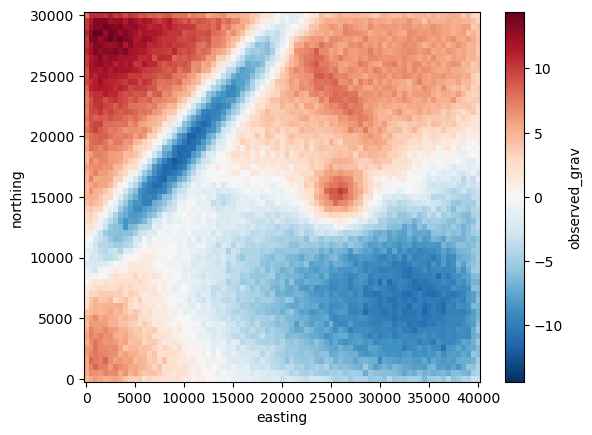

In [6]:
# contaminate gravity with 1 mGal of random noise
grav_df["observed_grav"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=0.5,
    percent=False,
    seed=0,
)

# grid the contaminated gravity
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

grav_grid.observed_grav.plot()
grav_df

## Regional estimation methods

### Filter

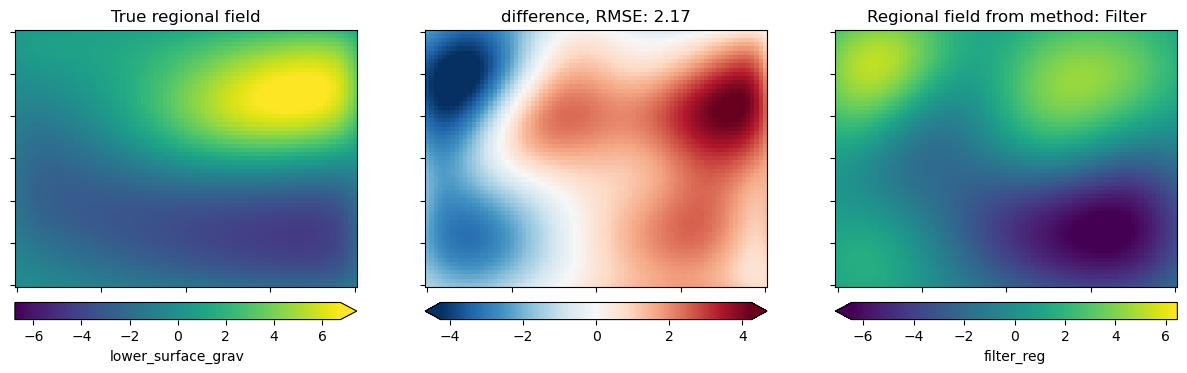

In [7]:
# estimate regional with a 30km low pass filter
grav_df = regional.regional_filter(
    filter_width=30e3,
    grav_grid=grav_grid.observed_grav,
    grav_df=grav_df,
    regional_col_name="filter_reg",
)

# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

# compare with true regional
_ = polar_utils.grd_compare(
    grav_grid.lower_surface_grav,
    grav_grid.filter_reg,
    plot_type="xarray",
    robust=True,
    plot=True,
    grid1_name="True regional field",
    grid2_name="Regional field from method: Filter",
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
)

### Trend

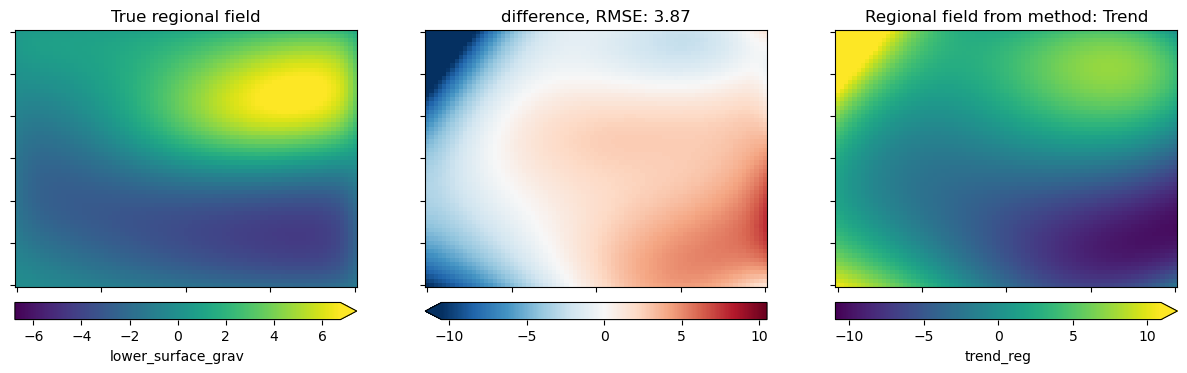

In [8]:
# estimate regional with fitting a 4th order trend
grav_df = regional.regional_trend(
    trend=4,
    grav_grid=grav_grid.observed_grav,
    grav_df=grav_df,
    fill_method="verde",
    regional_col_name="trend_reg",
)

# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

# compare with true regional
_ = polar_utils.grd_compare(
    grav_grid.lower_surface_grav,
    grav_grid.trend_reg,
    plot_type="xarray",
    robust=True,
    plot=True,
    grid1_name="True regional field",
    grid2_name="Regional field from method: Trend",
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
)

### Equivalent Sources

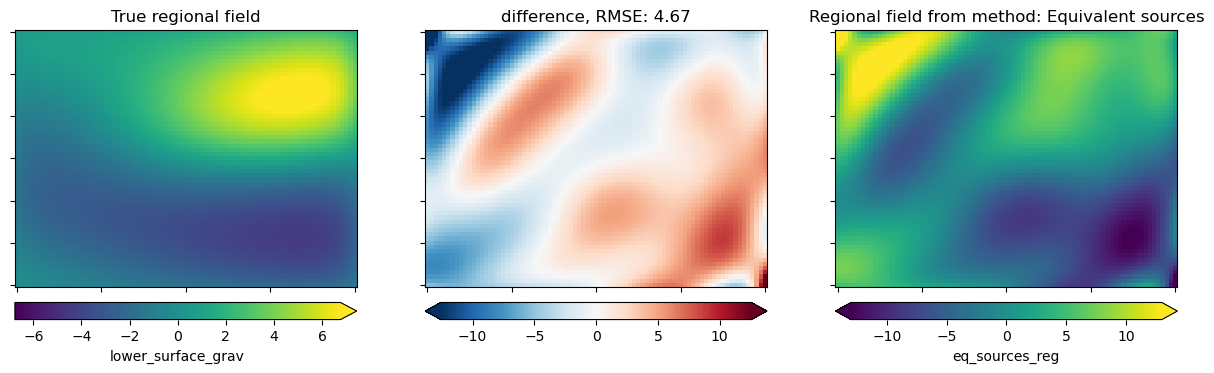

In [9]:
# estimate regional with fitting deep equivalent sources
grav_df = regional.regional_eq_sources(
    source_depth=-100e3,
    grav_df=grav_df,
    input_grav_name="observed_grav",
    eq_damping=None,
    block_size=2e3,
    regional_col_name="eq_sources_reg",
)

# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

# compare with true regional
_ = polar_utils.grd_compare(
    grav_grid.lower_surface_grav,
    grav_grid.eq_sources_reg,
    plot_type="xarray",
    robust=True,
    plot=True,
    grid1_name="True regional field",
    grid2_name="Regional field from method: Equivalent sources",
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
)

### Constraint point minimization

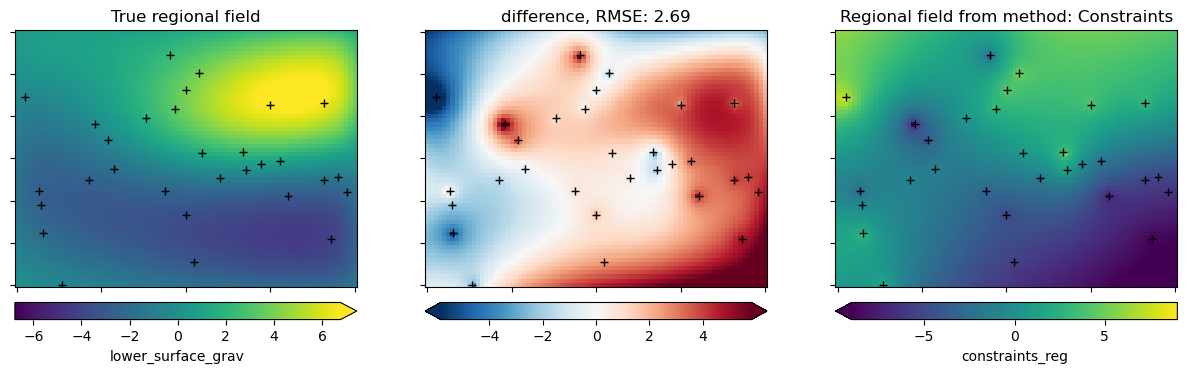

In [10]:
# estimate regional with the constraints method
grav_df = regional.regional_constraints(
    constraint_points=constraint_points,
    grav_grid=grav_grid.observed_grav,
    grav_df=grav_df,
    region=region,
    spacing=spacing,
    regional_col_name="constraints_reg",
    grid_method="pygmt",
    tension_factor=1,
)

# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

# compare with true regional
_ = polar_utils.grd_compare(
    grav_grid.lower_surface_grav,
    grav_grid.constraints_reg,
    plot_type="xarray",
    robust=True,
    plot=True,
    grid1_name="True regional field",
    grid2_name="Regional field from method: Constraints",
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

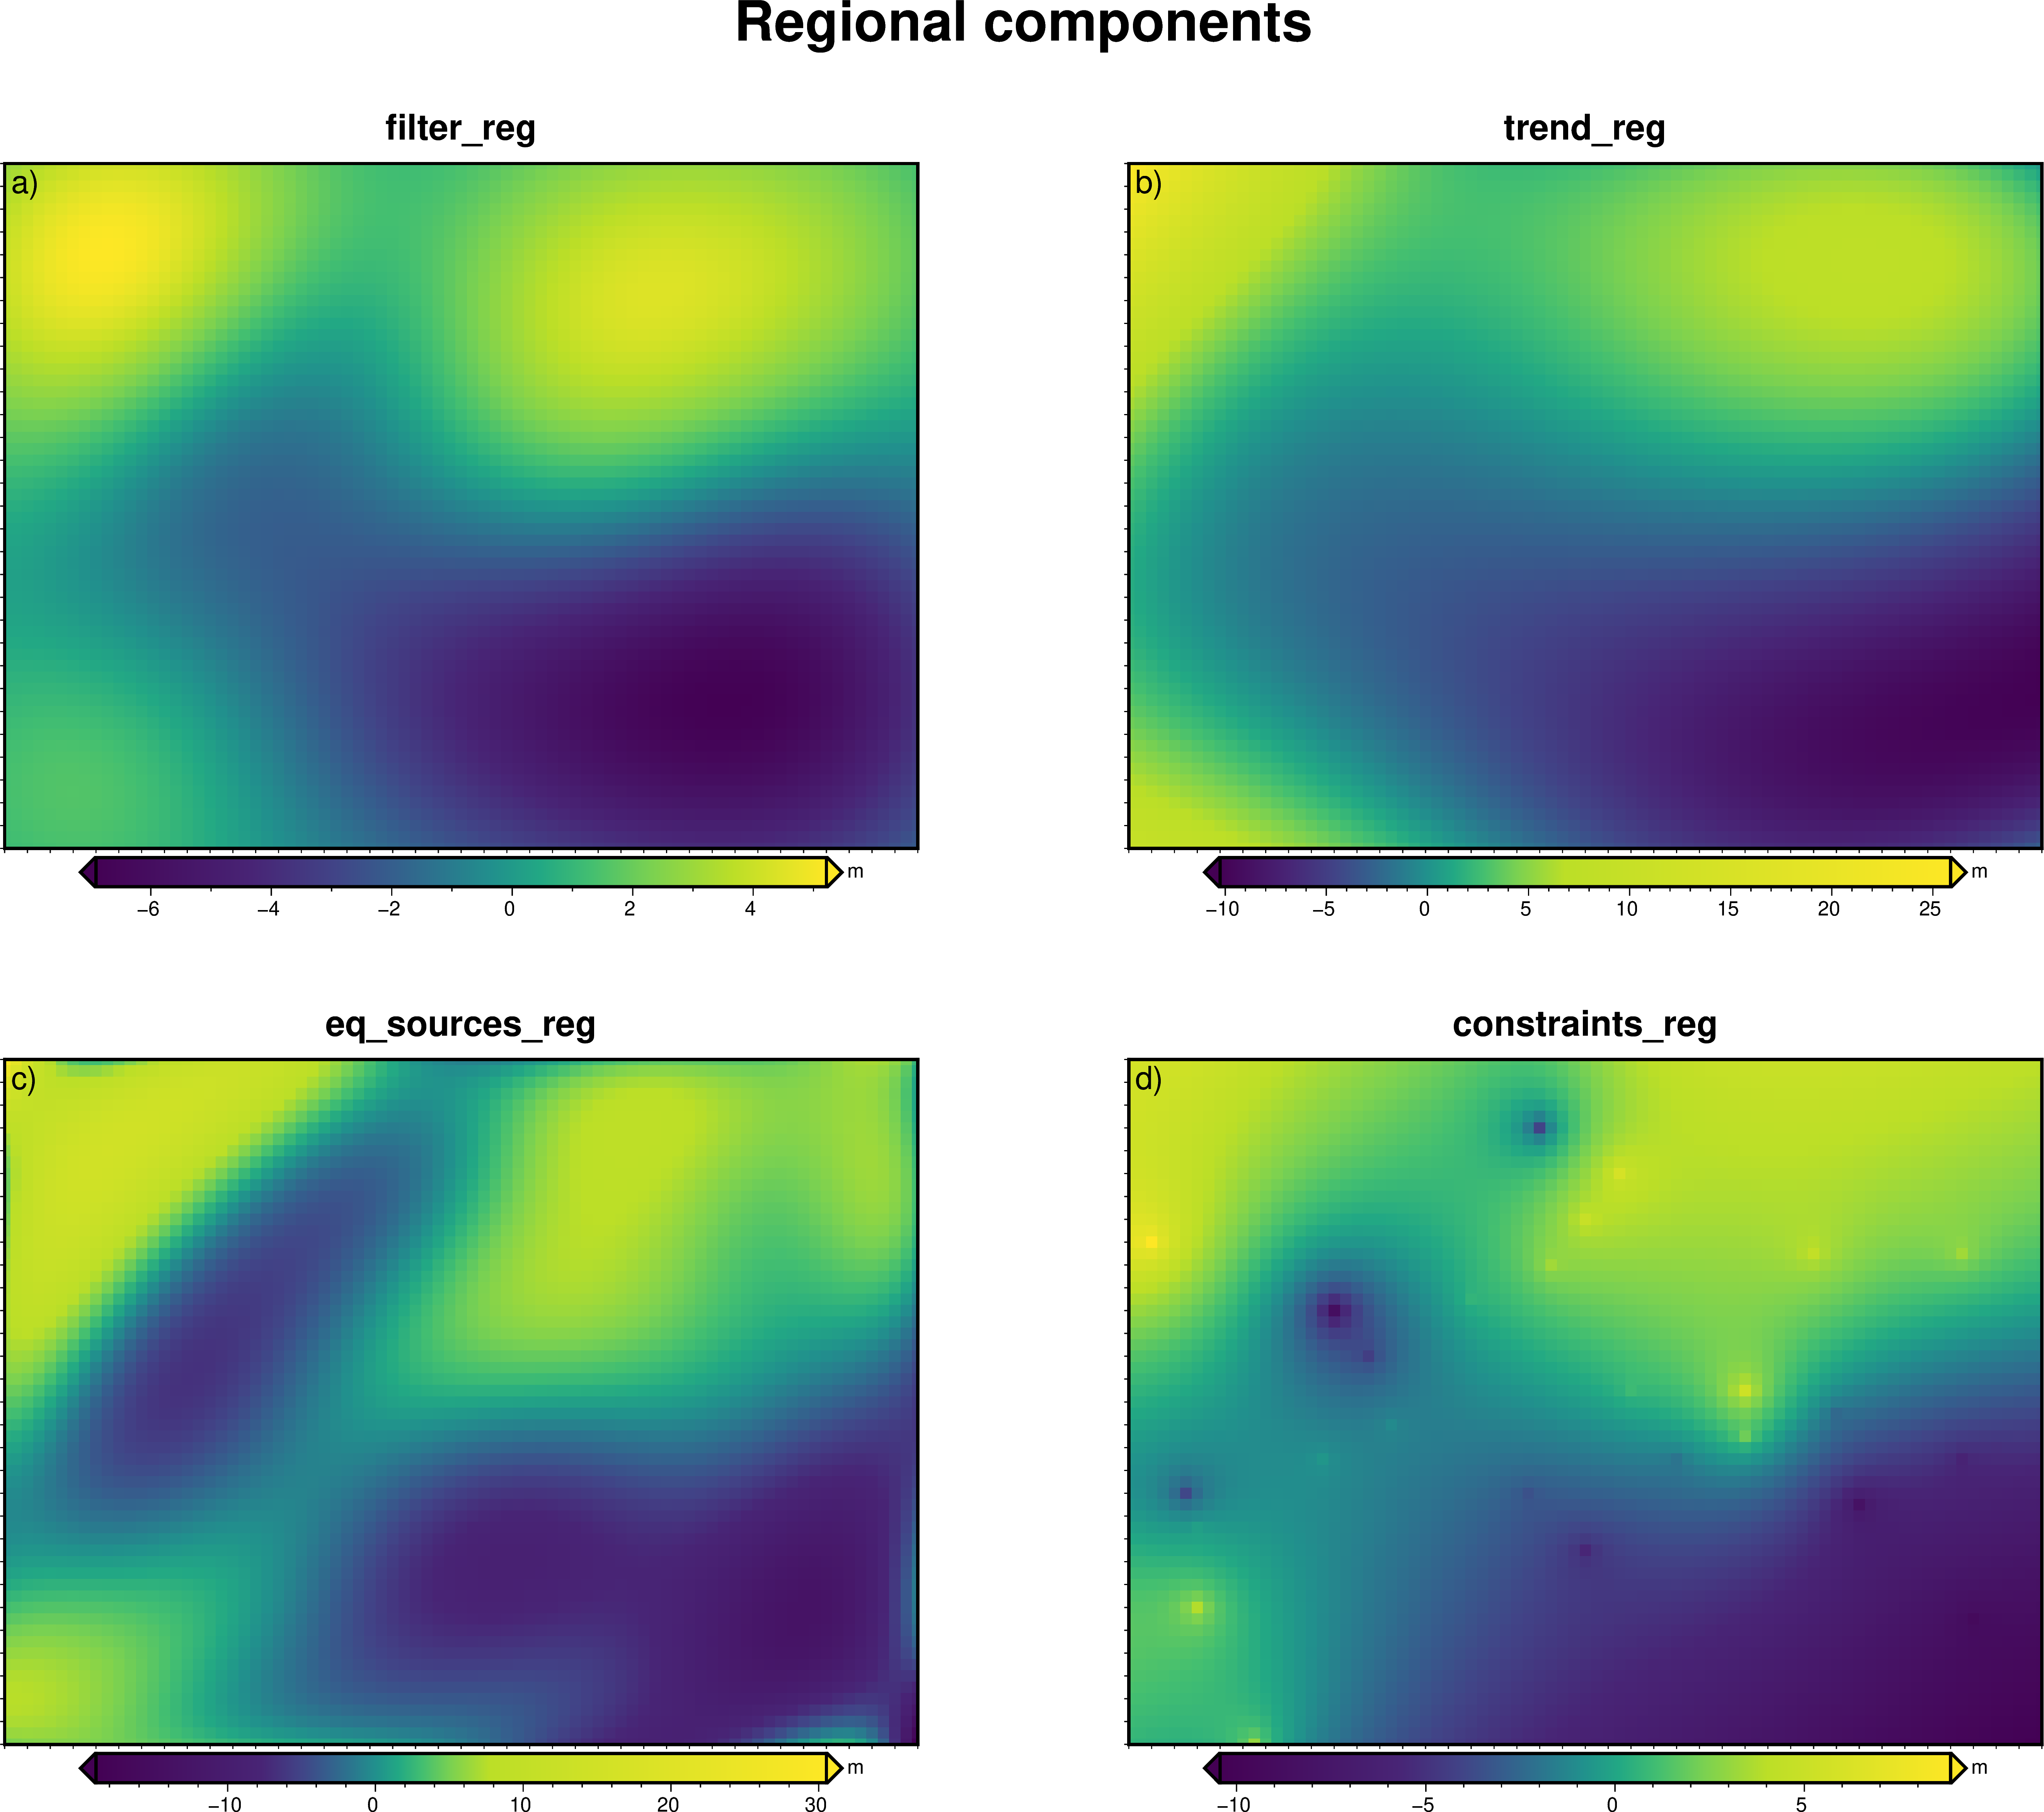

In [11]:
names = ["filter_reg", "trend_reg", "eq_sources_reg", "constraints_reg"]

fig = maps.subplots(
    [grav_grid[n] for n in names],
    region,
    margins="2c",
    fig_width=20,
    grd2cpt=True,
    fig_title="Regional components",
    subplot_titles=names,
    cbar_units=["m"] * len(names),
    autolabel=True,
)

fig.show()